In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
InputDir='/scratch/TESTS/Aim2/Inputs'
OutputDir='/scratch/TESTS/superResolution/outImageFiles'
MatlabFilesDir='/scratch/TESTS/superResolution/MatlabFiles'

label_fn = os.path.join(InputDir,'fswm_extended_neuro2012_20_merge_seg.nii.gz')
t1_fn = os.path.join(InputDir,'t1_average_BRAINSABC.nii.gz')
t2_fn = os.path.join(InputDir,'t2_average_BRAINSABC.nii.gz')
dwi_fn = os.path.join(InputDir,'DWI_Corrected_Aligned_CS.nrrd')

In [3]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
#PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release_20150715/bin'
PROGRAM_PATHS = '/scratch/BS/release-BSR/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from nipype.interfaces.ants import DenoiseImage
from nipype.interfaces.semtools import *

# Create Maximum Gradient Image

In [4]:
mgi_fn = os.path.join(OutputDir,'mgi.nrrd') # Maximum gradient image
BRIANSToolsPath = "/scratch/BS/release-BSR/bin"

!{BRIANSToolsPath}/BRAINSSuperResolution \
--inputMRVolumes {t1_fn},{t2_fn} \
--outputEdgeMap {mgi_fn}

Reading image: /scratch/TESTS/Aim2/Inputs/t1_average_BRAINSABC.nii.gz
Reading image: /scratch/TESTS/Aim2/Inputs/t2_average_BRAINSABC.nii.gz
Generating maximum gradient edgemap took 1.26236 s.
ERROR:  Could not read image .


T1: 
(174, 208, 186)
(-88.5, -88.5, -89.5)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(1.0, 1.0, 1.0)
T2: 
(174, 208, 186)
(-88.5, -88.5, -89.5)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(1.0, 1.0, 1.0)
MGI: 
(174, 208, 186)
(-88.5, -88.5, -89.5)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(1.0, 1.0, 1.0)


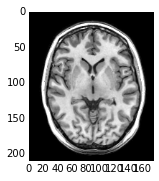

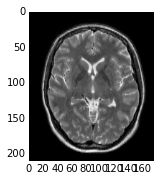

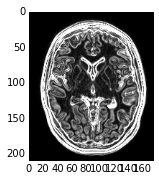

In [5]:
t1 = sitk.ReadImage(t1_fn)
t2 = sitk.ReadImage(t2_fn)
mgi = sitk.ReadImage(mgi_fn)

myshow(t1)
myshow(t2)
myshow(mgi)

print("T1: ")
print(t1.GetSize())
print(t1.GetOrigin())
print(t1.GetDirection())
print(t1.GetSpacing())

print("T2: ")
print(t2.GetSize())
print(t2.GetOrigin())
print(t2.GetDirection())
print(t2.GetSpacing())

print("MGI: ")
print(mgi.GetSize())
print(mgi.GetOrigin())
print(mgi.GetDirection())
print(mgi.GetSpacing())

In [6]:
# Now we read dwi image and extract its b0
myExtracter = extractNrrdVectorIndex()
myExtracter.inputs.inputVolume = dwi_fn
myExtracter.inputs.vectorIndex = 0
myExtracter.inputs.outputVolume = os.path.join(OutputDir,'dwi_b0.nrrd')
print(myExtracter.cmdline)
myExtracter.run()

INFO:interface:stdout 2016-06-02T20:54:09.172007:Input Image: /scratch/TESTS/Aim2/Inputs/DWI_Corrected_Aligned_CS.nrrd
INFO:interface:stdout 2016-06-02T20:54:09.172007:Output Image: /scratch/TESTS/superResolution/outImageFiles/dwi_b0.nrrd
INFO:interface:stdout 2016-06-02T20:54:09.172007:Vector Index: 0
INFO:interface:stdout 2016-06-02T20:54:09.172007:Set Image Orientation: AsAcquired
INFO:interface:stdout 2016-06-02T20:54:09.172007:
INFO:interface:Could not get resources used by process. Error: (pid=4425)


 extractNrrdVectorIndex  --inputVolume /scratch/TESTS/Aim2/Inputs/DWI_Corrected_Aligned_CS.nrrd --outputVolume /scratch/TESTS/superResolution/outImageFiles/dwi_b0.nrrd --vectorIndex 0


b0: 
(256, 256, 61)
(-140.12465793097655, -86.4420614591275, -72.24374524354596)
(0.9918539561569646, 0.05181217926069737, 0.11636678106760484, -0.028214547076287348, 0.9802080203863694, -0.19594942230972467, -0.12421621870375261, 0.19106997370202405, 0.9736850600478829)
(1.0, 1.0000000000000004, 2.4000000000000012)


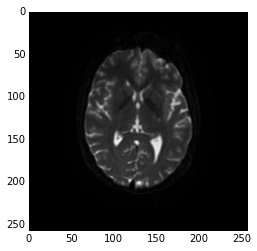

In [7]:
dwi_b0 = sitk.ReadImage(myExtracter.inputs.outputVolume)
myshow(dwi_b0)

print("b0: ")
print(dwi_b0.GetSize())
print(dwi_b0.GetOrigin())
print(dwi_b0.GetDirection())
print(dwi_b0.GetSpacing())

(256, 256, 146)
(-140.12465793097655, -86.4420614591275, -72.24374524354596)
(0.9918539561569646, 0.05181217926069737, 0.11636678106760484, -0.028214547076287348, 0.9802080203863694, -0.19594942230972467, -0.12421621870375261, 0.19106997370202405, 0.9736850600478829)
(1.0, 1.0, 1.0)


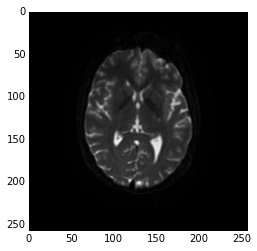

In [8]:
# upsampling dwi_b0 to edgemap resolution

new_size = [None]*3
new_size[0] = int( dwi_b0.GetSize()[0] * (dwi_b0.GetSpacing()[0]/mgi.GetSpacing()[0]) )
new_size[1] = int( dwi_b0.GetSize()[1] * (dwi_b0.GetSpacing()[1]/mgi.GetSpacing()[1]) )
new_size[2] = int( dwi_b0.GetSize()[2] * (dwi_b0.GetSpacing()[2]/mgi.GetSpacing()[2]) )
#print(new_size)

upsampler = sitk.ResampleImageFilter()
upsampler.SetInterpolator(sitk.sitkNearestNeighbor)
upsampler.SetOutputOrigin(dwi_b0.GetOrigin())
upsampler.SetOutputDirection(dwi_b0.GetDirection())
upsampler.SetOutputSpacing(mgi.GetSpacing()) # new resolution
upsampler.SetSize(new_size)
HD_NN_dwi_b0 = upsampler.Execute(dwi_b0)

myshow(HD_NN_dwi_b0)

print(HD_NN_dwi_b0.GetSize())
print(HD_NN_dwi_b0.GetOrigin())
print(HD_NN_dwi_b0.GetDirection())
print(HD_NN_dwi_b0.GetSpacing())

In [9]:
HD_NN_dwi_b0_fn = os.path.join(OutputDir,'HD_NN_dwi_b0.nrrd') # high-res upsampled dwi_b0
sitk.WriteImage(HD_NN_dwi_b0,HD_NN_dwi_b0_fn)

In [11]:
# Now resample the edgemap to the voxel space of the upsampled dwi_b0

resampled_mgi_fn = os.path.join(OutputDir,'resampled_mgi.nrrd')

resampler = BRAINSResample()
resampler.inputs.interpolationMode = 'Linear'
resampler.inputs.pixelType = 'uchar'
resampler.inputs.referenceVolume = HD_NN_dwi_b0_fn
resampler.inputs.inputVolume = mgi_fn
resampler.inputs.outputVolume = resampled_mgi_fn
resampler.run()

INFO:interface:stdout 2016-06-02T20:57:08.418572:WARNING: neither warpTransform nor deformationVolume are defined, so warpTransform is set as identity.
INFO:interface:stdout 2016-06-02T20:57:08.418572:=====================================================
INFO:interface:stdout 2016-06-02T20:57:08.418572:Input Volume:     /scratch/TESTS/superResolution/outImageFiles/mgi.nrrd
INFO:interface:stdout 2016-06-02T20:57:08.418572:Reference Volume: /scratch/TESTS/superResolution/outImageFiles/HD_NN_dwi_b0.nrrd
INFO:interface:stdout 2016-06-02T20:57:08.418572:Output Volume:    /scratch/TESTS/superResolution/outImageFiles/resampled_mgi.nrrd
INFO:interface:stdout 2016-06-02T20:57:08.418572:Pixel Type:       uchar
INFO:interface:stdout 2016-06-02T20:57:08.418572:Interpolation:    Linear
INFO:interface:stdout 2016-06-02T20:57:08.418572:Background Value: 0
INFO:interface:stdout 2016-06-02T20:57:08.418572:Warp By Transform: Identity
INFO:interface:stdout 2016-06-02T20:57:08.418572:=====================

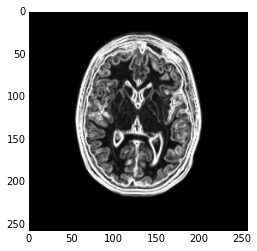

In [12]:
res_mgi = sitk.ReadImage(resampled_mgi_fn)
myshow(res_mgi)
#
# Now the input low-resolution image is dwi_b0
# the maximum gradient image is resampled_mgi
# They have same FOV

# TODO: 
# 1 - create edgemap from res_mgi
# 2 - create matlab files from dwi_b0 and res_mgi
# 3 - load them in matlab and try to run SR on dwi_b0